# Chap06 - 게이트가 추가된 RNN

> [Chap05-순환신경망(RNN)](https://github.com/ExcelsiorCJH/DLFromScratch2/blob/master/Chap05-Recurrent_Neural_Network/notebook.ipynb)에서 살펴본 RNN 구조는 순환경로를 통해 과거의 정보를 기억할 수 있었다. 하지만, 실제로는 성능이 좋지 못한데 그 이유는 장기(long term)의존 관계를 잘 학습할 수 없기 때문이다.  이번 장에서는 이러한 RNN의 단점을 보완한 LSTM, GRU에 대해서 다룬다. LSTM이나 GRU에는 **'게이트'**(gate)라는 구조가 더해져 있는데, 이 게이트 덕분에 시계열 데이터의 장기 의존 관계를 학습할 수 있다.

## 6.1 RNN의 문제점

- RNN의 문제점은 시계열 데이터의 장기 으존 관계(long-term dependency)를 학습하기 어렵다.

- 그 원인은 BPTT에서 기울기 소실 또는 기울기 폭발(vanishing & exploding gradient)이 일어나기 때문이다.

### 6.1.1 RNN 복습

<img src="./images/fig_6-1.png" height="70%" width="70%" />

- RNN 계층은 시계열 데이터인 $\mathbf{x}_{t}$를 입력하면 $\mathbf{h}_{t}$를 출력한다. 

- $\mathbf{h}_{t}$는 RNN 계층의 **은닉 상태(hidden state)**라고 하며, 과거 정보를 저장하는 역할을 한다.

- RNN cell의 내부를 자세히 살펴보면 아래의 그림과 같다.

<img src="./images/fig_6-2.png" height="50%" width="50%" />

### 6.1.2 기울기 소실 또는 기울기 폭발

<img src="./images/fig_6-3.png" height="70%" width="70%" />

- 위의 예시에서 `"?"`에 들어가는 단어는 "Tom"이다. 

- RNNLM이 이 문제에 올바르게 답하려면, "Tom was watching TV in his room."과  "Mary came into the room."이라는 정보를 기억해둬야 한다.

- 즉, 이러한 정보를 RNN 레이어의 hidden state에 인코딩해 보관해둬야 한다.

- 위의 예시에 대한 RNNLM의 BPTT는 아래의 그림과 같다.

<img src="./images/fig_6-4.png" height="60%" width="60%" />

- 위의 그림에서 RNN 레이어가 과거 방향으로 기울기(gradient)를 전달함으로써 시간 방향의 의존관계를 학습할 수 있게 된다.

- 이때의 기울기는 (이론적으로) 학습해야 할 정보가 들어 있고, 그것을 과거로 전달함으로써 장기 의존 관계를 학습한다.

- 하지만, 단순한 RNN(vanilla RNN) 레이어에서는 시간을 거슬러 올라갈수록 기울기가 작아지거나 커지는 문제가 발생한다(vanishing or exploding gradient).

### 6.1.3 기울기 소실과 기울기 폭발의 원인

<img src="./images/fig_6-5.png" height="70%" width="70%" />

- 위의 그림은 길이가 $T$인 시계열 데이터를 가정하여 $T$번째 정답 레이블로부터 전해지는 기울기가 어떻게 변화하는지 나타낸 그림이다.

- 이때, 시간 방향 기울기(gradient)를 살펴보면, 역전파로 전해지는 기울기는 차례로 `'tanh'` → `'+'` → `'MatMul'` 연산을 통과한다. 

- `'+'`의 역전파는 상류에서 전해지는 기울기를 그대로 하류로 흘려보내기 때문에 기울기의 값이 변하지 않지만, `'tanh'`와 `'MatMul'`은 변하게 된다.

#### tanh의 역전파

$$
y = \tanh{(x)} = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
$$

$$
\begin{align*}
\frac{\partial \tanh{(x)}}{\partial x} &= \frac{( e^x + e^{-x})(e^x + e^{-x}) - ( e^x - e^{-x})( e^x - e^{-x})}{( e^x + e^{-x})^{2}} \\ 
&= 1 - \frac{( e^x - e^{-x})( e^x - e^{-x})}{( e^x + e^{-x})^{2}} \\ 
&= 1 - \left\{ \frac{( e^x - e^{-x})}{( e^x + e^{-x})} \right\}^{2} \\
&= 1 - \tanh{(x)}^{2} \\
&= 1-y^{2}
\end{align*}
$$

<img src="./images/fig_6-6.png" height="40%" width="40%" />

- 위의 그래프에서 점선이 $y=\tanh{(x)}$의 미분이며, 그 값이 1.0 이하이고, $x$가 0으로 부터 멀어질수록 작아진다. 

- 따라서, 역전파에서 기울기가 $\tanh$ 노드를 지날때 마다 값은 계속해서 작아지게 된다. 

#### MatMul에서의 역전파

<img src="./images/fig_6-7.png" height="70%" width="70%" />

- 상류로부터 흘러온 기울기 $\mathbf{dh}$ `'MatMul'`노드에서의 역전파는 $\mathbf{dh} \cdot \mathbf{W_h}^{\mathsf{T}}$라는 행렬 곱이 된다.

- 이러한 행렬곱이 시계열 데이터의 time_step 만큼 반복한다. 

[5.54741272 5.002989   4.81288556 4.02369126 3.03544713 2.12245251
 1.70488804 1.55023843 0.35355553 0.27769917]


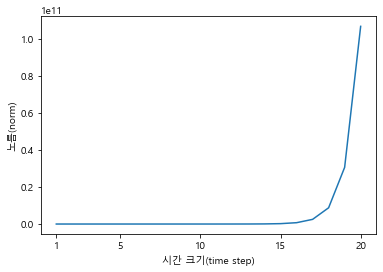

In [5]:
# chap06/rnn_gradient_graph.py
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)


N = 2  # 미니배치 크기
H = 10  # hidden state 벡터의 차원 수
T = 20  # 시계열 데이터의 길이(= timestep)

dh = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)
    
u, s, vh = np.linalg.svd(Wh)
print(s)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('시간 크기(time step)')
plt.ylabel('노름(norm)')
plt.show()